<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 8.3: Sentiment Analysis

This lab performs sentiment analysis on sentiment-labelled sentences using two types of feature extraction - a count vectoriser and TF-IDF vectoriser.

Based on the video tutorial **Text Classification with Machine Learning,SpaCy and Scikit(Sentiment Analysis)** by **Jesse E. Agbe (JCharis)**.

## Data Source: UCI
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/about) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

### Dataset
- [Sentiment Labelled Sentences Data Set](http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

### Abstract
The dataset contains sentences labelled with positive or negative sentiment.

- Data Set Characteristics: Text
- Number of Instances: 3000
- Area: N/A
- Attribute Characteristics: N/A
- Number of Attributes: N/A
- Date Donated: 2015-05-30
- Associated Tasks: Classification
- Missing Values? N/A

### Source
Dimitrios Kotzias dkotzias '@' ics.uci.edu

### Data Set Information
This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015

Please cite the paper if you want to use it :)

It contains sentences labelled with positive or negative sentiment.

### Format
sentence &lt;tab&gt; score &lt;newline&gt;

### Details
Score is either 1 (for positive) or 0 (for negative)

The sentences come from three different websites/fields:
- imdb.com
- amazon.com
- yelp.com

For each website, there exist **500 positive** and **500 negative** sentences. Those were selected randomly for larger datasets of reviews.

We attempted to select sentences that have a clearly positive or negative connotation, the goal was for no neutral sentences to be selected.

For the full datasets look:

- **imdb**: Maas et. al., 2011 _Learning word vectors for sentiment analysis_
- **amazon**: McAuley et. al., 2013 _Hidden factors and hidden topics: Understanding rating dimensions with review text_
- **yelp**: [Yelp dataset challenge](http://www.yelp.com/dataset_challenge)


### Attribute Information
The attributes are text sentences, extracted from reviews of products, movies, and restaurants

### Relevant Papers
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

### Citation Request
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

## Import libraries

In [1]:
## Import Libraries
import pandas as pd

import regex as re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

## Load data

Load Yelp, Amazon and Imdb Data into dataframes. Create three column names 'text', 'sentiment' and 'source' (equal to one of 'yelp', 'imdb' or 'amazon' for each dataframe).

Hint: Source is separated by tabs and has no headers.

In [2]:
yelp_text = 'yelp_labelled.txt'
imdb_text = 'imdb_labelled_fixed.txt'
amazon_text = 'amazon_cells_labelled.txt'

# ANSWER
dyelp = pd.read_csv('yelp_labelled.txt', header = None, sep = '\t')
dimdb = pd.read_csv('imdb_labelled_fixed.txt', header = None, sep = '\t') 
damazon = pd.read_csv('amazon_cells_labelled.txt', header = None, sep = '\t')
df_s = {'yelp': dyelp, 'imdb': dimdb, 'amazon': damazon}

## Inspect the data

Check your datasets.

In [4]:
# ANSWER
for ds in df_s.keys():
    print('Dataset: %s [%d row(s) x %d col(s)]' % (ds, df_s[ds].shape[0], df_s[ds].shape[1]))
    df_s[ds].columns = ['text', 'sentiment']
    df_s[ds]['source'] = ds
    print(df_s[ds].head())
    print('-' * 75)

Dataset: yelp [1000 row(s) x 2 col(s)]
                                                text  sentiment source
0                           Wow... Loved this place.          1   yelp
1                                 Crust is not good.          0   yelp
2          Not tasty and the texture was just nasty.          0   yelp
3  Stopped by during the late May bank holiday of...          1   yelp
4  The selection on the menu was great and so wer...          1   yelp
---------------------------------------------------------------------------
Dataset: imdb [1000 row(s) x 2 col(s)]
                                                text  sentiment source
0  A very, very, very slow-moving, aimless movie ...          0   imdb
1  Not sure who was more lost - the flat characte...          0   imdb
2  Attempting artiness with black & white and cle...          0   imdb
3       Very little music or anything to speak of.            0   imdb
4  The best scene in the movie was when Gerardo i...          1  

## Merge the data

Merge all three datasets.

In [10]:
# ANSWER
dfs = pd.concat(df_s.values(), ignore_index = True)

In [12]:
print('Dataset: %s [%d row(s) x %d col(s)]\n' % ('All', dfs.shape[0], dfs.shape[1]))
print(dfs.info())
print(dfs.sample(10))
print('-' * 75)

Dataset: All [3000 row(s) x 3 col(s)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3000 non-null   object
 1   sentiment  3000 non-null   int64 
 2   source     3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB
None
                                                   text  sentiment  source
1824  Mark my words, this is one of those cult films...          1    imdb
2484                                I love this phone!.          1  amazon
2118                       It has been a winner for us.          1  amazon
115                                       Check it out.          1    yelp
233   Ordered a double cheeseburger & got a single p...          0    yelp
2416                An Awesome New Look For Fall 2000!.          1  amazon
1996  Unfortunately, any virtue in this film's produ...          0    imdb
2412

In [14]:
dfs.shape

(3000, 3)

In [16]:
print(dfs.columns)

Index(['text', 'sentiment', 'source'], dtype='object')


In [18]:
dfs.head()

,text,sentiment,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


## Prepare the stage
- Load spaCy

In [20]:
nlp = spacy.load('en_core_web_sm')

## Prepare the text
All the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international characters
- handle symbols
- handle metadata and embedded information
- handle repetitions (such multiple spaces or newlines)

Clean text.

In [22]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [29]:
# Apply the clean_text function to your dataset.
# ANSWER
dfs['text'] = dfs['text'].apply(clean_text)

## Work the text
Using techniques learned in previous labs, remove StopWords, punctuation, and digits. Entities can be retained. Return the lemmatised form of any remaining words in lower case form.

This removes meaningless information.

In [31]:
# Complete the function
def convert_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    
    for w in sent:
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)
   
    return text

In [35]:
%%time
dfs['short'] = dfs['text'].apply(convert_text)

CPU times: user 24.2 s, sys: 495 ms, total: 24.7 s
Wall time: 25.6 s


In [74]:
dfs.sample(10)

,0,1,short
2094,Dont waste your money...,0,not waste money
1648,This movie does an excellent job of revealing ...,1,movie excellent job reveal complexity task inc...
314,"Great food for the price, which is very high q...",1,great food price high quality house
65,"Great food and service, huge portions and they...",1,great food service huge portion military discount
1760,"Technically, the film is well made with impres...",1,technically film impressive camera work solid ...
2909,Seller shipped quickly and much cheaper than t...,1,Seller ship quickly cheap competitor
769,* Both the Hot & Sour & the Egg Flower Soups w...,1,hot sour egg flower soups absolutely star
2385,The worst piece of crap ever along with the Ve...,0,bad piece crap Verizon customer service
2307,"As many people complained, I found this headse...",0,people complain find headset microphone weak
1905,"One of the most boring,pointless movies I have...",0,boring pointless movie see


## Split the dataset

In [42]:
# Features and Labels
X = dfs['short']
y = dfs['sentiment']

# Apply a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Create a Bag-of-Words Model

In [44]:
# create a matrix of word counts from the text
counts = CountVectorizer()

In [46]:
# do the actual counting
A = counts.fit_transform(X_train, y_train)

In [51]:
pd.DataFrame(A.todense(), columns=counts.get_feature_names_out()).head()

,00,10,11,13,15,15pm,17,20th,2mp,30,...,yucky,yukon,yum,yummy,yun,z500a,zero,zillion,zombie,zombiez
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# create a classifier using SVC
classifier = SVC(kernel='linear', probability=True)

In [55]:
# train the classifier with the training data
classifier.fit(A, y_train)

SVC(kernel='linear', probability=True)

In [57]:
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = counts.transform(X_test)

In [59]:
# make predictions based on the test data
predictions = classifier.predict(B)

# store probabilities of predictions being 1
probabilities = classifier.predict_proba(B)[:, 1]

In [61]:
# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7733


## Repeat using TF-IDF
TF-IDF = Term Frequency - Inverse Document Frequency

In [63]:
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A = tfidf.fit_transform(X_train, y_train)

# train the classifier with the training data
classifier.fit(A, y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = tfidf.transform(X_test)

# make predictions based on the test data
predictions = classifier.predict(B)

# store probabilities of predictions being 1
probabilities = classifier.predict_proba(B)[:, 1]

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7800


In [66]:
pd.DataFrame(A.todense(), columns=counts.get_feature_names_out()).head()

,00,10,11,13,15,15pm,17,20th,2mp,30,...,yucky,yukon,yum,yummy,yun,z500a,zero,zillion,zombie,zombiez
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Defining a helper function to show results and charts

In [68]:

def show_summary_report(actual, prediction, probabilities):

    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, probabilities)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, probabilities)
    average_precision = average_precision_score(actual, probabilities)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')

    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()

    return (accuracy_, precision_, recall_, roc_auc_)

## Repeating it all for comparison
Repeat the whole lot in one big block using the show_summary_report function.

Find 'Accuracy', 'Precision', 'Recall', 'ROC_AUC' using CountVectorizer and TfidfVectorizer and keep the result in a dataframe.

*********
* Count *
*********
Accuracy : 0.7733 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7857 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7599 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8728                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


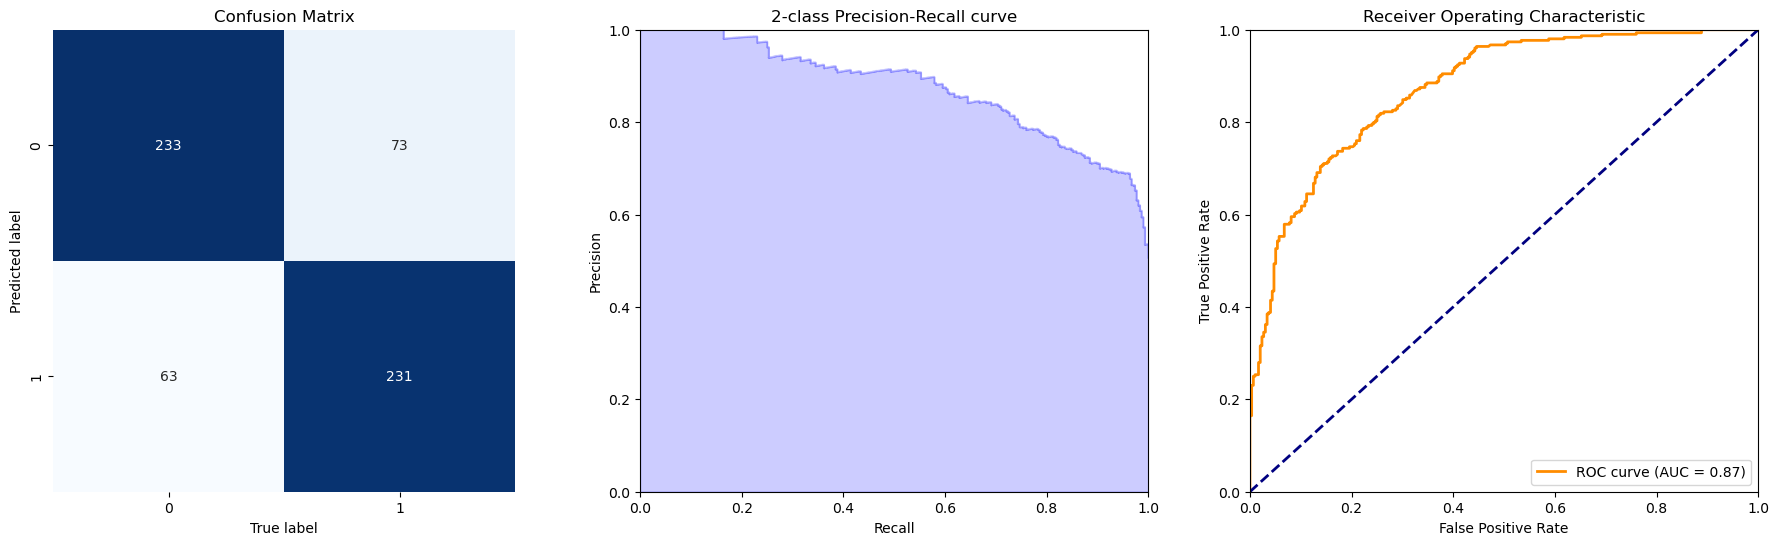

**********
* TF-IDX *
**********
Accuracy : 0.7800 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7925 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7664 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8820                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


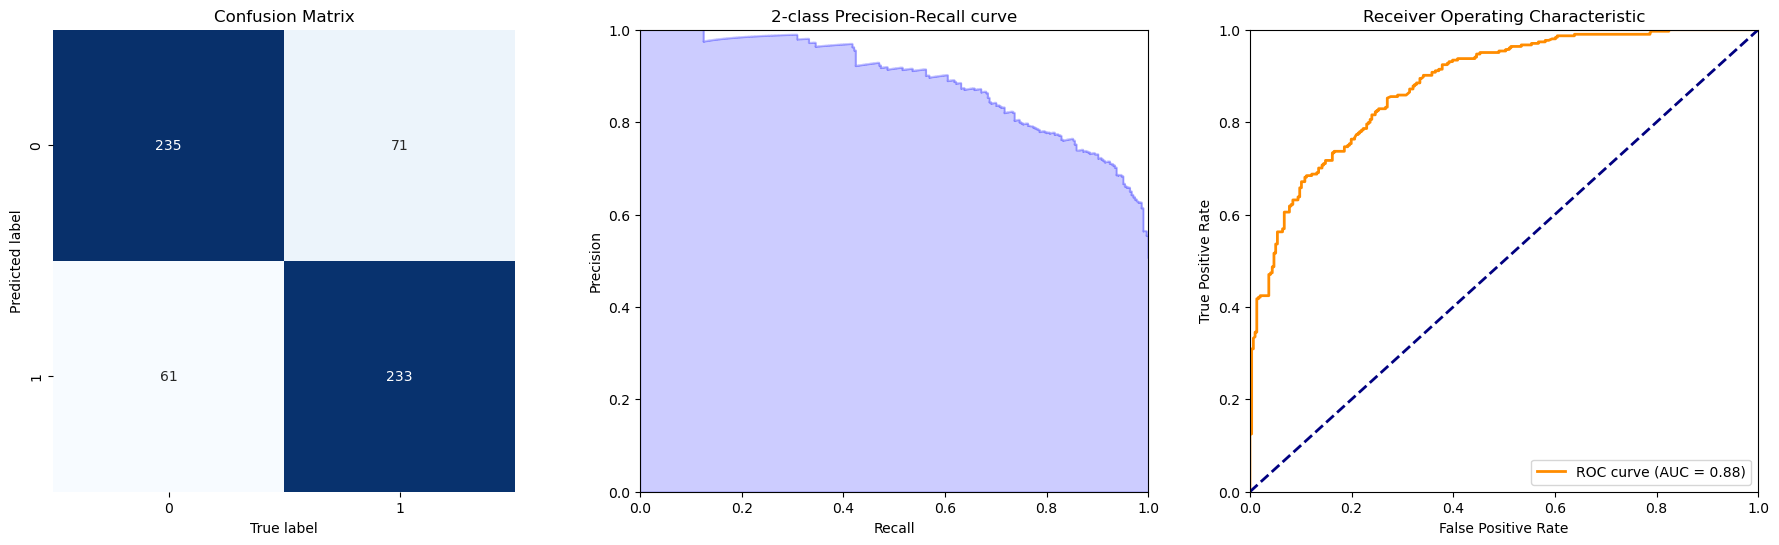

In [71]:
# ANSWER

results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))

   
    counts = m
    A = counts.fit_transform(X_train, y_train)

    classifier = SVC(kernel='linear', probability=True)

    classifier.fit(A, y_train)

    B = counts.transform(X_test)

    predictions = classifier.predict(B)

    probabilities = classifier.predict_proba(B)[:, 1]

    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)

    results.loc[i] = {'Model': models[i],
                      'Accuracy': accuracy_,
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}

## Bonus: Sentiment analysis with a pre-trained Large Language Model

In this section we perform the sentiment analysis using a fine-tuned version of the Distilbert Large Language Model. Distilbert is a lighter-weight modification of BERT (which was developed by Google AI), having 60% as many parameters while maintaining 95% of the performance. The fine tuning is carried out on the SST2 (Stanford Sentiment Treebank v2) dataset (further details at https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).

This model will be accessed via [Hugging Face](https://huggingface.co/). If you have not already done so from Demo 8.4, sign up for a free account at https://huggingface.co/ and then create a new token ('Read' type) via https://huggingface.co/settings/tokens . Copy-paste it into an empty text file called 'hf_token.txt'.

In [79]:
# import libraries for accessing the Hugging Face model
import json
import requests

In [90]:
with open(r"hf_token.txt", 'r') as file: # this file contains only the token created via  https://huggingface.co/settings/tokens
    HUGGINGFACEHUB_API_TOKEN = file.read().strip()

FileNotFoundError: [Errno 2] No such file or directory: 'hf_token.txt'

In [ ]:
API_URL = "https://api-inference.huggingface.co/models/distilbert/distilbert-base-uncased-finetuned-sst-2-english"
headers = {"Authorization": f"Bearer {HUGGINGFACEHUB_API_TOKEN}"}

The following function makes an API request to the model and returns a response in JSON form.

In [ ]:
def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

Observe the structure of the output when a couple of sentences are applied as inputs:

In [ ]:
output = query({
	"inputs": ["This is a fantastic product.", "No way is this possible!"]
})

output # wait for the model to load if an error message appears at first

The following code extracts the probability of positive predictions:

In [ ]:
[x['score'] if x['label'] == 'POSITIVE' else 1-x['score'] for x in output[0]]

Based on this a function is created to take in an output from the LLM and produce arrays of predictions and probabilities:

In [ ]:
def llm_predict(output):
    probs = [x['score'] if x['label'] == 'POSITIVE' else 1-x['score'] for x in output[0]]
    preds = [round(x) for x in probs]
    return np.array(preds), np.array(probs)

Next we shall evaluate this model on X_test, y_test.

In [ ]:
output = query({"inputs": list(X_test.values)})

Use the above `llm_predict` to calculate predictions and probabilities on `output` and then call the `show_summary_report` function to evaluate the performance on the test set.

In [ ]:
# ANSWER


Note that the original pre-cleaned dataset is better suited to the model as it was trained on similar text. Next we evaluate performance on the original dataset.

In [ ]:
# reload the original merged dataset with 3000 rows and 3 columns, the first row of data should have
# Wow... Loved this place. 	1 	yelp

df = #ANSWER

In [ ]:
df.head()

,text,sentiment,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
...,...,...,...
2995,The screen does get smudged easily because it ...,0,amazon
2996,What a piece of junk.. I lose more calls on th...,0,amazon
2997,Item Does Not Match Picture.,0,amazon
2998,The only thing that disappoint me is the infra...,0,amazon


Find the sentiment scores for the text of df:

In [ ]:
output = query({"inputs": list(df['text'].values)})

Similar to above, use the `llm_predict` function on this output and then call `show_summary_report` to find how the LLM performs on the original dataset.

In [ ]:
# ANSWER

You should find that results are significantly better here.

## Summary

Sentiment analysis models were developed using both a count vectoriser and TF-IDF vectoriser to extract numerical features, trained on reviews text data using a support vector classifier. Their performances were evaluated and later compared to that of a Large Language Model.



---



---



> > > > > > > > > © 2025 Institute of Data


---



---



